## Часть 1
Напишите скрипт, который скачивает  сообщения с Телеграм-канала https://t.me/Sputnik_results . Сохраните сообщения в формате по вашему выбору (.csv, .jsonl, sqlite, parquet, и т.д.). Откройте с помощью Pandas или Arrow, постройте график числа сообщений в зависимости от даты. 

In [210]:
import json
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import re
import seaborn as sns
sns.set_context("notebook")
sns.set_style("whitegrid")

In [183]:
with open("../data/messages.json", 'r', encoding ='utf-8') as file:
    messages = json.load(file)

In [184]:
offset = datetime.timedelta(hours=3)
tz = datetime.timezone(offset, name='МСК')

In [185]:
df = pd.DataFrame(messages)
df['date'] = pd.to_datetime(df['date']).dt.tz_convert(tz).dt.tz_localize(None)
df['time'] = df['date'].dt.time
df['date'] = df['date'].dt.date
df['message'] = df['message'].replace({"": None})
df = df.dropna()
df.info()
df.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21002 entries, 0 to 22645
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       21002 non-null  int64 
 1   date     21002 non-null  object
 2   from_id  21002 non-null  int64 
 3   message  21002 non-null  object
 4   time     21002 non-null  object
dtypes: int64(2), object(3)
memory usage: 984.5+ KB


,id,date,from_id,message,time
22641,134519,2021-11-17,98736263,"#ревак Спутником-V 16 ноября в 15:00, сразу же...",18:07:12
22642,134520,2021-11-17,2145141996,"Добрый день, я поставила прививку 03.11 а 10.1...",18:10:55
22643,134521,2021-11-17,411259144,обсуждения в чате @sputnik_is_starting. Здесь ...,18:11:57
22644,134524,2021-11-17,915878674,@duggarrik неделю читает правила чата.,18:28:29
22645,134525,2021-11-17,1045778687,"М34\nСпутникЛайт\nХроники, естественно, никако...",19:01:17


In [186]:
df.from_id.value_counts().head(6)

1060884316    540
411259144     342
609983163     231
915878674     156
321348666     126
430829243      50
Name: from_id, dtype: int64

In [187]:
df[df.from_id == 915878674].head()

,id,date,from_id,message,time
4349,32916,2021-01-27,915878674,Ж40. Без хронических болезней. V1 24.10.2020 н...,20:33:36
7045,60648,2021-02-14,915878674,Update 13.02.21 113 дней 07-206 Хеликс АТ 72.2,00:47:12
11227,90924,2021-03-28,915878674,Update: 155 день 64.8 Diasorin,09:52:06
12698,103274,2021-04-25,915878674,183 день Эббот и Диасорин,17:57:32
13545,110772,2021-05-20,915878674,"Укажите, пожалуйста, даты прививок",07:38:46


у кого много сообщений - админы - пересылают сообщения из других чатов, а еще пишут сообщения о том, что нельзя общаться

всякие инфопосты в выборку не попали, фото и другое отбросили

### Часть 2
1.Напишите функции для извлечения данных из сообщений:
   - пол участника
   - возраст участника

   Постройте диаграммы для визуализации. 

2.Реализуйте какой-либо анализ этих данных на ваше усмотрение. Например их можно кластеризовать и интерпретировать кластеры, или попробовать выделить статистику по среднему количеству антител в зависимости от возраста, или посчитать количество заболевших после вакцинации. Обязательная визуализация. 

In [188]:
# sex_age_reg = "([МЖ])[, ]*(\d+(?!\d*.\d))|(\d+)[, ]*([МЖ])[^\w]"
sex_age_reg = "([МЖ])[, ]*(\d+(?!\d*.\d))"

def find_sex_age(s):
    match = re.findall(sex_age_reg, s, flags=re.MULTILINE)
    sex, age = None, None
    if match:
        sex, age = match[0]
        age = int(age)
    return [sex, age]

matches = df.message.apply(find_sex_age).values

df['sex'] = [i[0] for i in matches]
df['age'] = [i[1] for i in matches]

In [189]:
def find_score(s):
    s = s.lower()
    matches = [re.findall(f"(\d+|\d+[,.]\d*)\s*({reg})", s, flags=re.MULTILINE) for reg in ["bau", "ое|oe", "au|ae", "ед"]]
    scores = {
        "BAU/ml": None,
        "OE/ml": None,
        "AU/ml": None,
        "ед/мл": None,
    }
    for match, key in zip(matches, scores.keys()):
        if match is not None and match:
            # print(match)
            score, _ = match[-1]
            score = float(score.replace(',', '.'))
            scores[key] = score
    return scores

scores = pd.DataFrame(df.message.apply(find_score).values.tolist())
for col in scores.columns:
    df[col] = scores[col]
scores_cols = scores.columns

def transform_scores(df):
    df = df.copy()
    df["ед/мл"] = df["ед/мл"] / 7
    df["OE/ml"] = 2.6 * df["OE/ml"]
    df["AU/ml"] = df["AU/ml"] / 7
    df = df.fillna(method='bfill', axis=1)
    return df["BAU/ml"]
df["Score"] = transform_scores(df[scores_cols])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21002 entries, 0 to 22645
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       21002 non-null  int64  
 1   date     21002 non-null  object 
 2   from_id  21002 non-null  int64  
 3   message  21002 non-null  object 
 4   time     21002 non-null  object 
 5   sex      13305 non-null  object 
 6   age      13305 non-null  float64
 7   BAU/ml   628 non-null    float64
 8   OE/ml    606 non-null    float64
 9   AU/ml    151 non-null    float64
 10  ед/мл    340 non-null    float64
 11  Score    1426 non-null   float64
dtypes: float64(6), int64(2), object(4)
memory usage: 2.1+ MB


In [190]:
df.reset_index(drop=True).to_feather("../data/messages.feather")

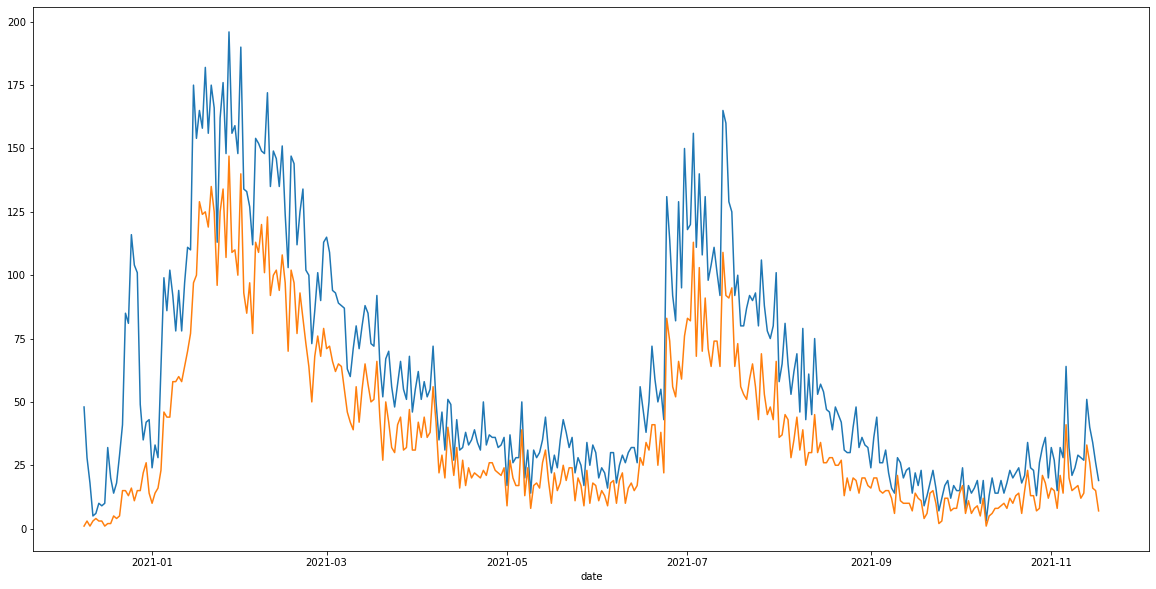

In [191]:
fig, ax = plt.subplots(figsize=(20, 10))
df.groupby('date')['id'].count().plot(ax=ax)
_ = df.dropna(subset=["age"]).groupby('date')['age'].count().plot(ax=ax)

In [192]:
df = df.dropna(subset=['age'])
df['age'] = df['age'].astype(int)
df = df.query("5 < age < 100")
# df['sex0'] = df['sex'].map({'М': 1, "Ж": 0})
df = df.reset_index(drop=True)

In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13299 entries, 0 to 13298
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       13299 non-null  int64  
 1   date     13299 non-null  object 
 2   from_id  13299 non-null  int64  
 3   message  13299 non-null  object 
 4   time     13299 non-null  object 
 5   sex      13299 non-null  object 
 6   age      13299 non-null  int32  
 7   BAU/ml   381 non-null    float64
 8   OE/ml    416 non-null    float64
 9   AU/ml    98 non-null     float64
 10  ед/мл    220 non-null    float64
 11  Score    916 non-null    float64
dtypes: float64(5), int32(1), int64(2), object(4)
memory usage: 1.2+ MB


In [194]:
df.dropna(subset=scores_cols, how='all')

,id,date,from_id,message,time,sex,age,BAU/ml,OE/ml,AU/ml,ед/мл,Score
122,2673,2020-12-28,187777622,"М34, первая вакцина 07.12 вечером, на след. де...",07:36:58,М,34,NaN,NaN,NaN,400.0,57.142857
213,3852,2021-01-02,642901826,"Ж43, v1 - 28.12 (в 16.00) После вакцинации чер...",11:43:30,Ж,43,NaN,NaN,NaN,17.0,2.428571
249,4713,2021-01-04,152211786,"Ж46, V1 30.12\nТолько немного болело плечо и л...",15:52:46,Ж,46,NaN,NaN,NaN,10.0,1.428571
445,7308,2021-01-08,47086537,"М, 30. V1 - 08.01.21 - введение дозы 12:40, в ...",21:35:00,М,30,NaN,369.0,NaN,NaN,959.400000
509,7890,2021-01-09,717072527,Ж58. V1 делала 2 января. Без побочных эффектов.,23:00:41,Ж,58,NaN,NaN,NaN,175.0,25.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
12444,130147,2021-09-08,1209280289,"М, 31. Спутник Лайт в Медси, 3.09 в 19:00. бол...",10:27:23,М,31,88.0,NaN,NaN,NaN,88.000000
12452,130196,2021-09-09,186279945,#ревак Ж51 участник КИ первый компонент 25.11....,07:57:32,Ж,51,891.5,NaN,NaN,NaN,891.500000
12455,130236,2021-09-09,438808604,"Ж 36\nДТЗ, ВСД, хрон. тонзиллит.\n\n16.12.20-4...",13:20:51,Ж,36,33.4,NaN,NaN,NaN,33.400000
12465,130292,2021-09-10,648231181,"Ж22 Спутник. Первая доза 9.09.2021. Увеит, ад...",13:46:31,Ж,22,225.0,NaN,NaN,NaN,225.000000


In [195]:
df.sex.value_counts(normalize=True)

Ж    0.615159
М    0.384841
Name: sex, dtype: float64

In [196]:
df[df['age'] < 18]

,id,date,from_id,message,time,sex,age,BAU/ml,OE/ml,AU/ml,ед/мл,Score
36,971,2020-12-21,179605718,"Просили писать даже если ничего нет. Пишу, 51 ...",21:45:59,М,13,NaN,NaN,NaN,NaN,NaN
10189,120859,2021-07-12,421534161,#дети #вакцинация #КИ\nМ15 Морозовская больниц...,14:30:39,М,15,NaN,NaN,NaN,NaN,NaN
11682,126458,2021-08-07,251718911,Пишу за ребёнка М6 лет закрыт дома как контакт...,05:36:45,М,6,NaN,NaN,NaN,NaN,NaN
12400,129920,2021-09-05,421534161,#дети #вакцинация #КИ\nМ15 Морозовская больниц...,09:52:25,М,15,203.0,NaN,NaN,NaN,203.0
12415,129981,2021-09-06,158638098,#дети #вакцинация\nЖ15\nV1 08.07.2021 Пфайзер....,02:44:40,Ж,15,NaN,NaN,NaN,NaN,NaN
12675,131390,2021-10-01,1202788021,"М17, астма\nБолел ковидом в конце декабря-нача...",22:09:48,М,17,NaN,NaN,NaN,NaN,NaN
13019,133230,2021-11-02,404324333,М13. Вакцинировался #pfizer\nПервая доза-02.11...,19:46:44,М,13,NaN,NaN,NaN,NaN,NaN
13164,133811,2021-11-10,784235167,"М13, вакцина #pfizer #дети\n1 доза 8.11 первые...",09:40:46,М,13,NaN,NaN,NaN,NaN,NaN
13190,134004,2021-11-12,322828600,"#дети Ж 15 лет, без хронических болезней и осо...",10:49:12,Ж,15,NaN,NaN,NaN,NaN,NaN
13224,134158,2021-11-13,212620743,"#дети Москва\nМ, 14. Спутник М #спутникМ\nV1 1...",20:32:26,М,14,NaN,NaN,NaN,NaN,NaN


In [197]:
df.age.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
age,13299.0,39.623731,13.713363,6.0,30.0,36.0,46.0,94.0


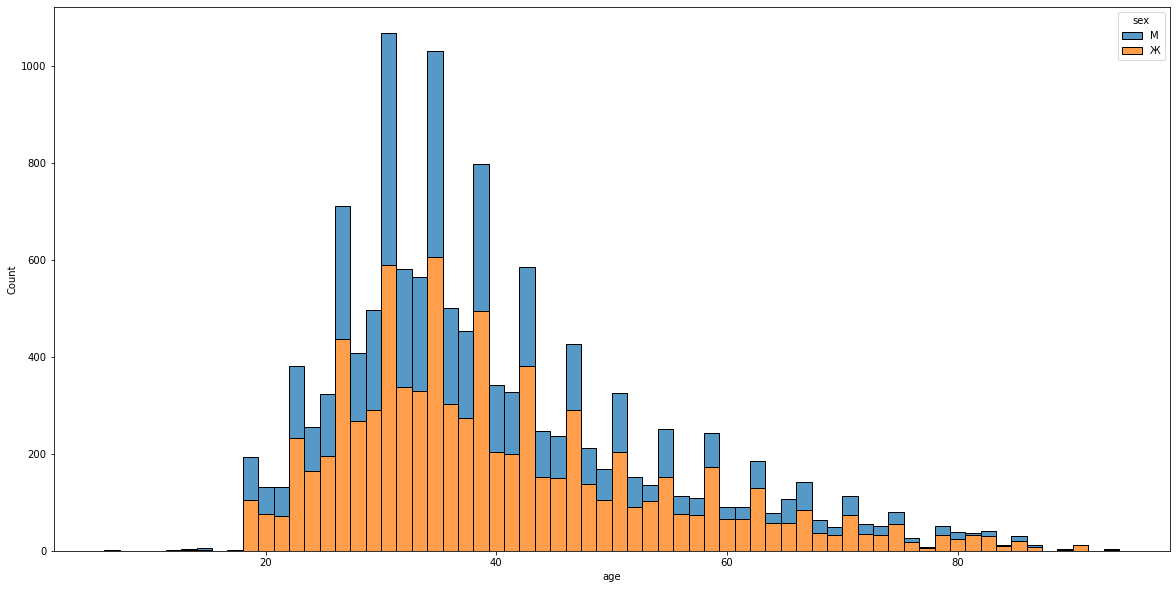

In [198]:
fig, ax = plt.subplots(figsize=(20, 10))
_ = sns.histplot(df, x='age', hue='sex', multiple='stack', ax=ax)

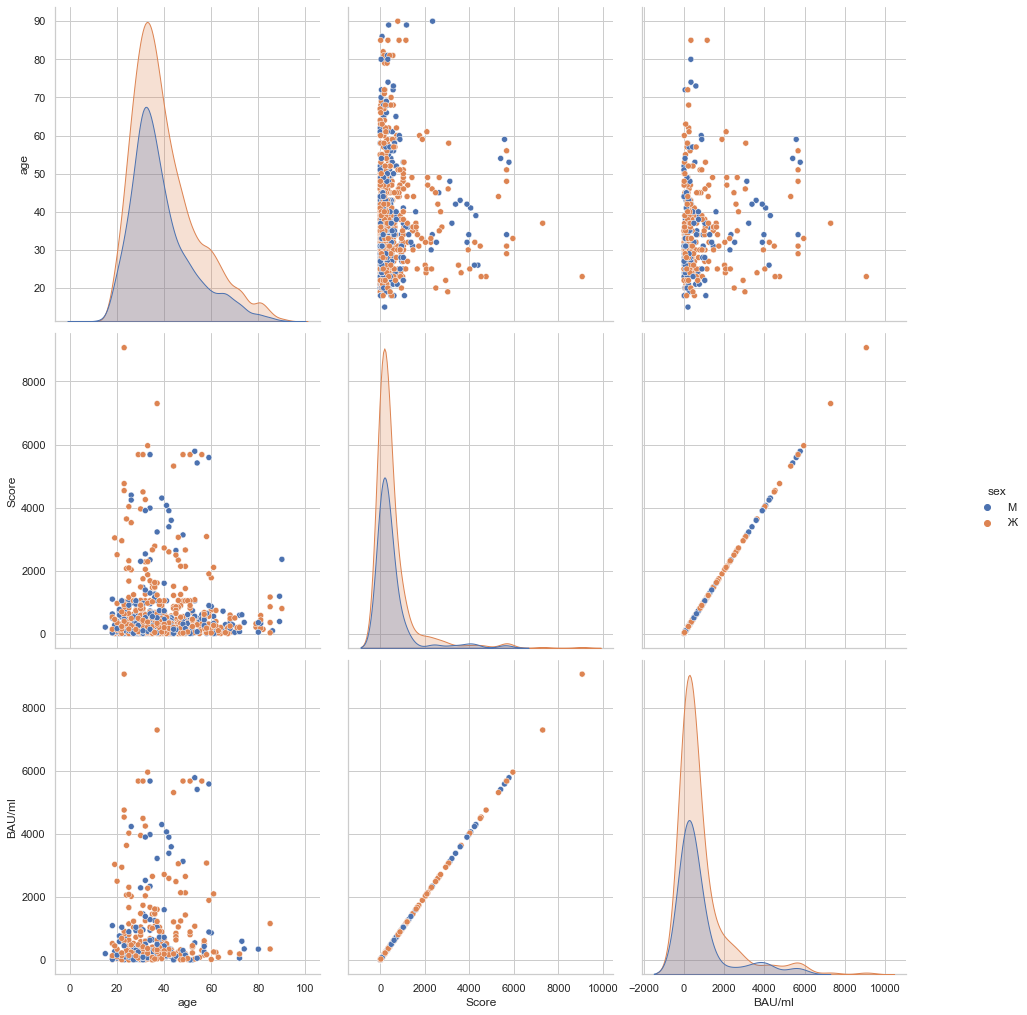

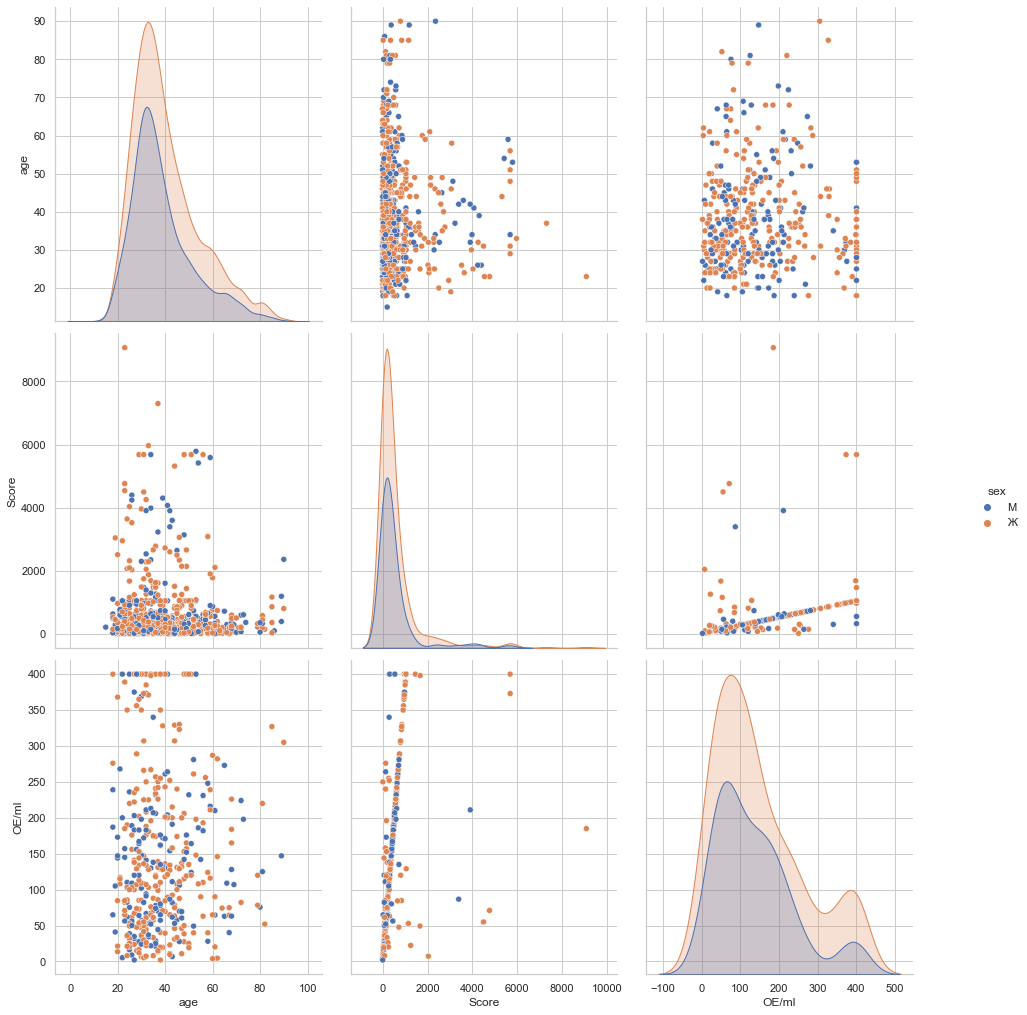

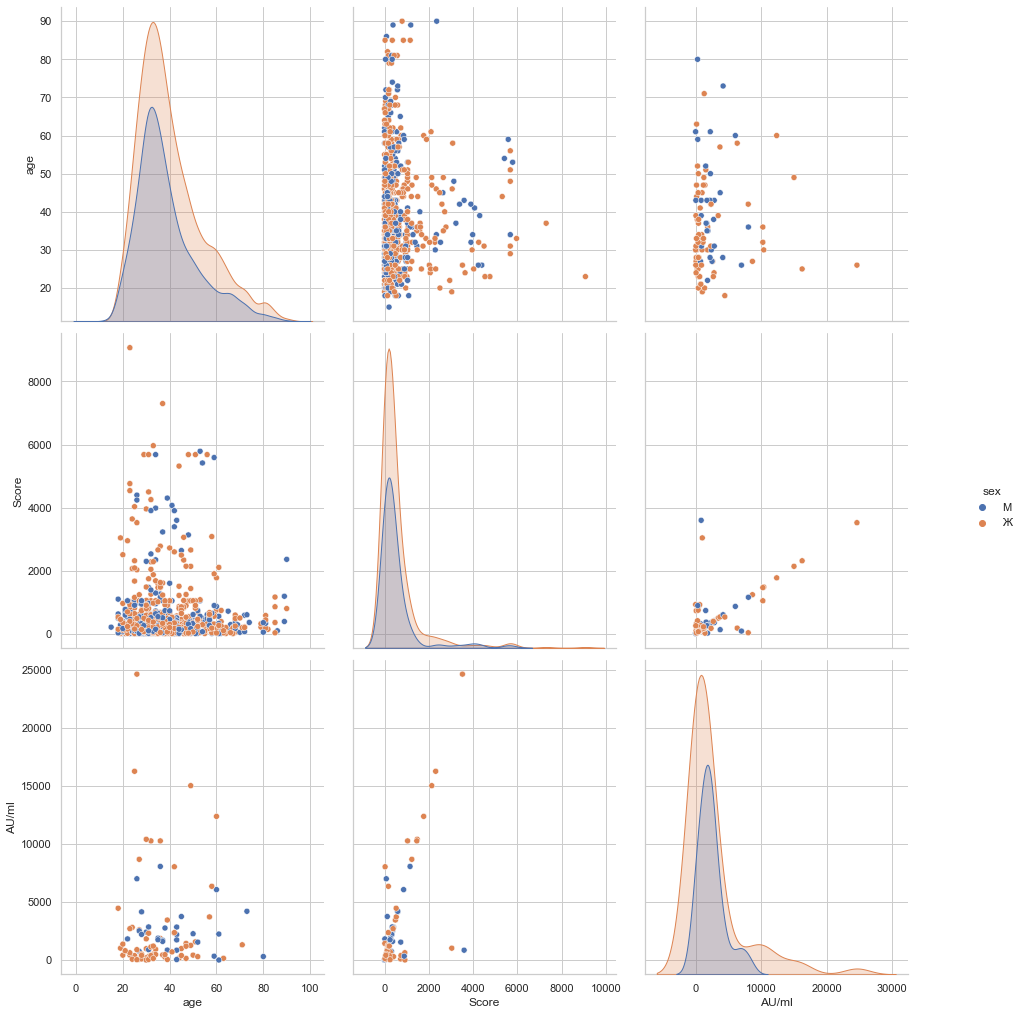

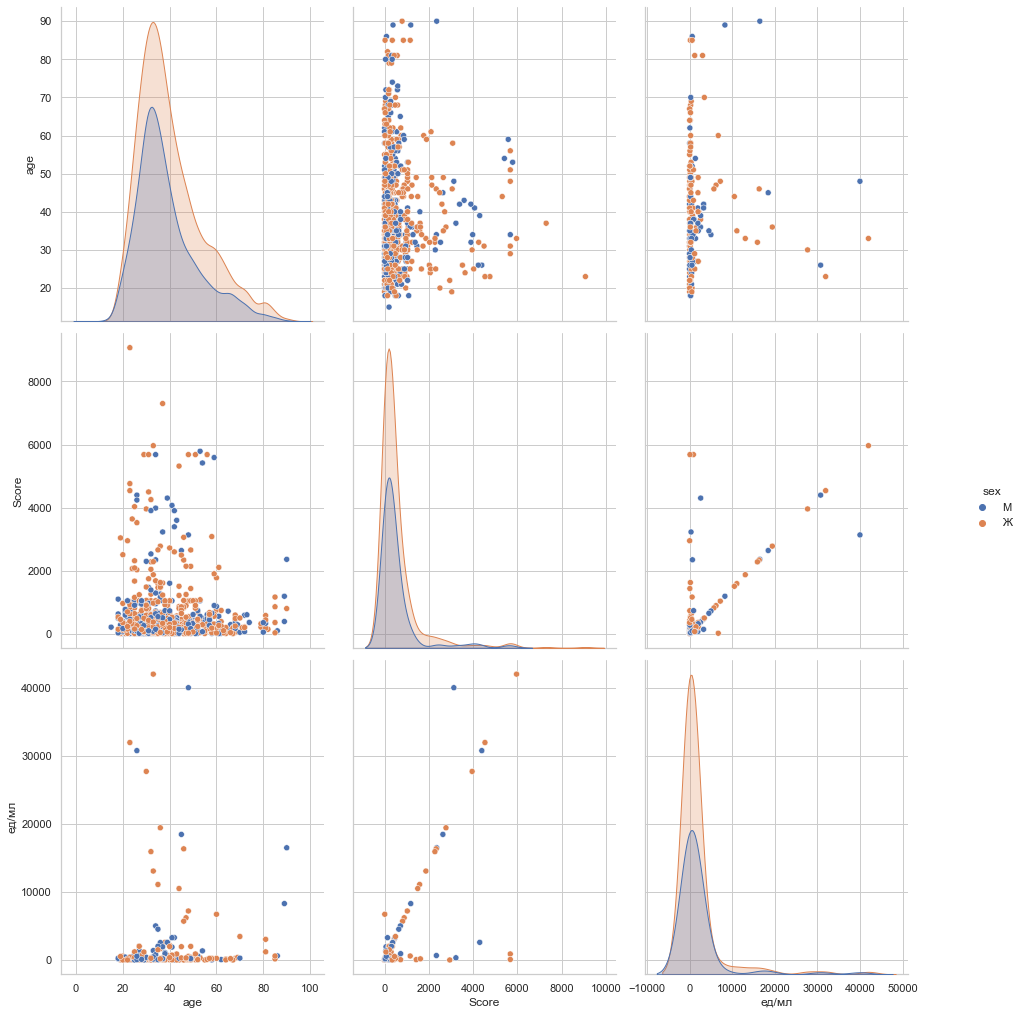

In [211]:
# features = ["Score"] + scores_cols
for feature in scores_cols:
    _ = sns.pairplot(df, vars=['age', "Score", feature], hue='sex')
    _.fig.set_size_inches(15, 15)

In [202]:
# print(*df.message.sample(400), sep='\n')

## ML

In [203]:
df = pd.read_feather("../data/messages.feather")
df = df.dropna(subset=['age'])
df['age'] = df['age'].astype(int)
df = df.query("5 < age < 100")
df = df.reset_index(drop=True)

In [204]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13299 entries, 0 to 13298
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       13299 non-null  int64  
 1   date     13299 non-null  object 
 2   from_id  13299 non-null  int64  
 3   message  13299 non-null  object 
 4   time     13299 non-null  object 
 5   sex      13299 non-null  object 
 6   age      13299 non-null  int32  
 7   BAU/ml   381 non-null    float64
 8   OE/ml    416 non-null    float64
 9   AU/ml    98 non-null     float64
 10  ед/мл    220 non-null    float64
 11  Score    916 non-null    float64
dtypes: float64(5), int32(1), int64(2), object(4)
memory usage: 1.2+ MB


,id,date,from_id,message,time,sex,age,BAU/ml,OE/ml,AU/ml,ед/мл,Score
0,215,2020-12-09,293006292,М37. Первый компонент 03.12.2020 в 17:00. Чере...,23:05:05,М,37,NaN,NaN,NaN,NaN,NaN
1,255,2020-12-10,1200836347,М 48. Без симтомов. Тест на 30 день. вакцина 1...,08:00:09,М,48,NaN,NaN,NaN,NaN,NaN
2,344,2020-12-10,312251578,"Ж34, 9 декабря первая доза, через 3 часа озноб...",22:14:44,Ж,34,NaN,NaN,NaN,NaN,NaN
3,347,2020-12-10,44473357,Ж32. Первая доза 7 декабря. Ночью небольшой оз...,22:46:58,Ж,32,NaN,NaN,NaN,NaN,NaN
4,372,2020-12-11,79373564,"М, 30, первый компонент 8 декабря.\nПобочных э...",13:23:21,М,30,NaN,NaN,NaN,NaN,NaN
